In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec
import glob
import netCDF4 as ncdf
from pynhhd import nHHD

import time

from datetime import datetime

# Local import 

from spectra.py_spectra import *


In [ ]:
#-------------------------------------------------------------------------------------

def remove_trend(fld, print_info):
    """
    Implementing Errico's (MWR 1985) 1D / 2D detrending algorithm
    
    """
    if len(fld.shape) == 1:
        
        ny = fld.shape
        
        sy = (fld[-1] - fld[0]) / (ny-1)
        
        scale = 0.5*(2*np.arange(1,ny+1) - ny - 1)
        
        fldy = fld - sy*scale
        
        return fldy
        
    elif len(fld.shape) == 2:
        
        ny, nx = fld.shape

        sy = (fld[-1,:] - fld[0,:]) / (ny-1)

        scale = 0.5*(2*np.arange(1,ny+1) - ny - 1)

        scale2d = np.broadcast_to(scale[:,np.newaxis], fld.shape)

        sy2d    = np.broadcast_to(   sy[np.newaxis,:], fld.shape)

        fldy = fld - scale2d*sy2d

        sx = (fldy[:,-1] - fldy[:,0]) / (nx-1)


In [11]:
ds = xr.open_dataset("/work/wicker/ECONUS/2022050400_RRFS_ECONUS.nc")

nz = 20

klevels = np.arange(nz)

u = np.nan_to_num(ds.u_interp.isel(fhour=3,nz=klevels).values).astype('float64')
v = np.nan_to_num(ds.v_interp.isel(fhour=3,nz=klevels).values).astype('float64')
w = np.nan_to_num(ds.w_interp.isel(fhour=3,nz=klevels).values).astype('float64')

ny, nx = u.shape[1:3]

print(u.shape)

dims = (ny, nx)  # Z Y, X

dx   = (3, 3)  # dz, dy, dx

ur = np.zeros((nz, ny, nx))
vr = np.zeros((nz, ny, nx))
ud = np.zeros((nz, ny, nx))
vd = np.zeros((nz, ny, nx))
uh = np.zeros((nz, ny, nx))
vh = np.zeros((nz, ny, nx))

for k in klevels:

    u[k] = remove_trend(u[k], None)
    v[k] = remove_trend(v[k], None)
    
    vfield = np.stack((u[k], v[k]), axis=2)

    nhhd = nHHD(grid=dims, spacings=dx)

    nhhd.decompose(vfield)

    ur[k], vr[k] = np.squeeze(np.split(nhhd.r, 2, axis=2))

    ud[k], vd[k] = np.squeeze(np.split(nhhd.d, 2, axis=2))

    uh[k], vh[k] = np.squeeze(np.split(nhhd.h, 2, axis=2))
    
divx = (ur[:,:,2:] - ur[:,:,:-2]) / 6.0
divy = (vr[:,2:,:] - vr[:,:-2,:]) / 6.0

dtotal = divx[1:-1,1:-1,:] + divy[1:-1,:,1:-1]

print("Del dot Rot: ", dtotal.max(), dtotal.min())
    

# dv/dx - du/dy
rotz = (vd[:,1:-1,2:] - vd[:,1:-1,:-2]) / 6.0 - (ud[:,2:,1:-1] - ud[:,:-2,1:-1]) / 6.0

print("Del cross Div: ",rotz.max(), rotz.min())
    

   # dv/dx - du/dy
rotz = (vh[:, 1:-1, 2:] - vh[:, 1:-1, :-2]) / 6.0 - (uh[:, 2:, 1:-1] - uh[:, :-2, 1:-1]) / 6.0

print("Harmonic Rotz: ",rotz.max(), rotz.min())
    

divx = (uh[:,:,2:] - uh[:,:,:-2]) / 6.0
divy = (vh[:,2:,:] - vh[:,:-2,:]) / 6.0

dtotal = divx[1:-1,1:-1,:] + divy[1:-1,:,1:-1]

print("Harmonic Div: ", dtotal.max(), dtotal.min())


(20, 959, 1155)
Del dot Rot:  1.1934897514720433e-15 -1.1934897514720433e-15
Del cross Div:  8.881784197001252e-16 -9.71445146547012e-16
Harmonic Rotz:  4.563996622591503 -3.9471786795829003
Harmonic Div:  3.110571025232939 -2.7042719669745012


In [3]:

ures = u[n] - ur[n] - ud[n] - uh[n]
vres = v[n] - vr[n] - vd[n] - vh[n]
print("URES:  ", ures.max(), ures.min())
print("VRES:  ", vres.max(), vres.min())

NameError: name 'u' is not defined

In [4]:
#-----------------------------------------------------------------
#
# This code can run and plot power spectra from a single day
#

def run_spectral_analysis(in_dir, out_dir, day, suffix_name = ["HRRR_ECONUS", "RRFS_ECONUS"], analysis_levels = [4, 18, 32]):
    

    # hrrr_nhhd_file = str(os.path.join(in_dir, "%s_%s_nhhd2D.nc" % (day, suffix_name[0])))
    # rrfs_nhhd_file = str(os.path.join(in_dir, "%s_%s_nhhd2D.nc" % (day, suffix_name[1])))

    hrrr_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[0])))
    rrfs_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[1])))
    
    hrrr_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[0])))
    rrfs_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[1])))
    
    print(hrrr_nhhd_file, hrrr_full_file)
    print(rrfs_nhhd_file, rrfs_full_file)
    
    # Open data sets

    hrrr_nhhd = xr.open_dataset(hrrr_nhhd_file) 
    rrfs_nhhd = xr.open_dataset(rrfs_nhhd_file)
    
    zlevels = hrrr_nhhd.z
    
    hrrr_full = xr.open_dataset(hrrr_full_file) 
    rrfs_full = xr.open_dataset(rrfs_full_file)

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these three levels are averaged together

        klevels = [k-1, k, k+1]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u  = np.nan_to_num(hrrr_full.u_interp.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_v  = np.nan_to_num(hrrr_full.v_interp.isel(fhour=1,nz=klevels).values).astype('float64')

        hrrr_ur = np.nan_to_num(hrrr_nhhd.ur.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_vr = np.nan_to_num(hrrr_nhhd.vr.isel(fhour=1,nz=klevels).values).astype('float64')
        
        hrrr_ud = np.nan_to_num(hrrr_nhhd.ud.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_vd = np.nan_to_num(hrrr_nhhd.vd.isel(fhour=1,nz=klevels).values).astype('float64')

        hrrr_uh = np.nan_to_num(hrrr_nhhd.ud.isel(fhour=1,nz=klevels).values).astype('float64')
        hrrr_vh = np.nan_to_num(hrrr_nhhd.vd.isel(fhour=1,nz=klevels).values).astype('float64')

        hrrr_ke  = 0.5*(hrrr_u**2  + hrrr_v**2)
        hrrr_rke = 0.5*(hrrr_ur**2 + hrrr_vr**2)
        hrrr_dke = 0.5*(hrrr_ud**2 + hrrr_vd**2)
        hrrr_hke = 0.5*(hrrr_uh**2 + hrrr_vh**2)
        
        rrfs_u  = np.nan_to_num(rrfs_full.u_interp.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_v  = np.nan_to_num(rrfs_full.v_interp.isel(fhour=1,nz=klevels).values).astype('float64')

        rrfs_ur = np.nan_to_num(rrfs_nhhd.ur.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_vr = np.nan_to_num(rrfs_nhhd.vr.isel(fhour=1,nz=klevels).values).astype('float64')

        rrfs_ud = np.nan_to_num(rrfs_nhhd.ud.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_vd = np.nan_to_num(rrfs_nhhd.vd.isel(fhour=1,nz=klevels).values).astype('float64')
         
        rrfs_uh = np.nan_to_num(rrfs_nhhd.uh.isel(fhour=1,nz=klevels).values).astype('float64')
        rrfs_vh = np.nan_to_num(rrfs_nhhd.vh.isel(fhour=1,nz=klevels).values).astype('float64')
        
        rrfs_ke  = 0.5*(rrfs_u**2  + rrfs_v**2)
        rrfs_rke = 0.5*(rrfs_ur**2 + rrfs_vr**2)
        rrfs_dke = 0.5*(rrfs_ud**2 + rrfs_vd**2)
        rrfs_hke = 0.5*(rrfs_uh**2 + rrfs_vh**2)

        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        if k < 8:
            ylim = [1.0e8,1.0e18]
        else:
            ylim = [1.0e10,1.0e20]
            
        axis    = 0
        func    = get_spectra2D_RAD
        detrend = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs_ke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linestyle='dotted', linewidth=2.0, ylim=ylim)      
        plot_spectra(hrrr_ke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='k', linestyle='dotted', linewidth=2.0, ylim=ylim) 

        plot_spectra(rrfs_rke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linewidth=2.0, ylim=ylim)      
        plot_spectra(rrfs_dke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linestyle='--',ylim=ylim) 
        plot_spectra(hrrr_rke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='k', linewidth=2.0, ylim=ylim) 
        plot_spectra(hrrr_dke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\n\nRRFS:red',
                    ptitle='Rotational and Divergent KE', linecolor='k', linestyle='--', LinsborgSlope=True, ylim=ylim)
        
#         ax1 = fig.add_subplot(gs[0, 1])
#         if k < 8:
#             ylim = [1.0e8,1.0e18]
#         else:
#             ylim = [1.0e10,1.0e20]
        
#         plot_spectra(rrfs_hke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', linecolor='r', linewidth=2.0, ylim=ylim)      
#         plot_spectra(hrrr_hke,  func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\nRRFS:red',
#                     ptitle='Harmonic KE', linecolor='k', linewidth=2.0, LinsborgSlope=True, ylim=ylim)

        plt.suptitle("Rotational and Divergent KE Avg Case Day %s \n Height Level: %3.1f km" % (day, zlevels[k]/1000.), fontsize=20)

        plt.savefig("%s/%s_%s_%3.1fkm.png" % (out_dir, day, 'Rotational and Divergent_KE_Spectra', zlevels[k]/1000.),bbox_inches='tight', dpi=300)


Running day:  2022050400

/work/wicker/ECONUS/2022050400_HRRR_ECONUS_hhd.nc /work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc
/work/wicker/ECONUS/2022050400_RRFS_ECONUS_hhd.nc /work/wicker/ECONUS/2022050400_RRFS_ECONUS.nc
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = True

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = True

                    ---------------------------------------------------------------------------------

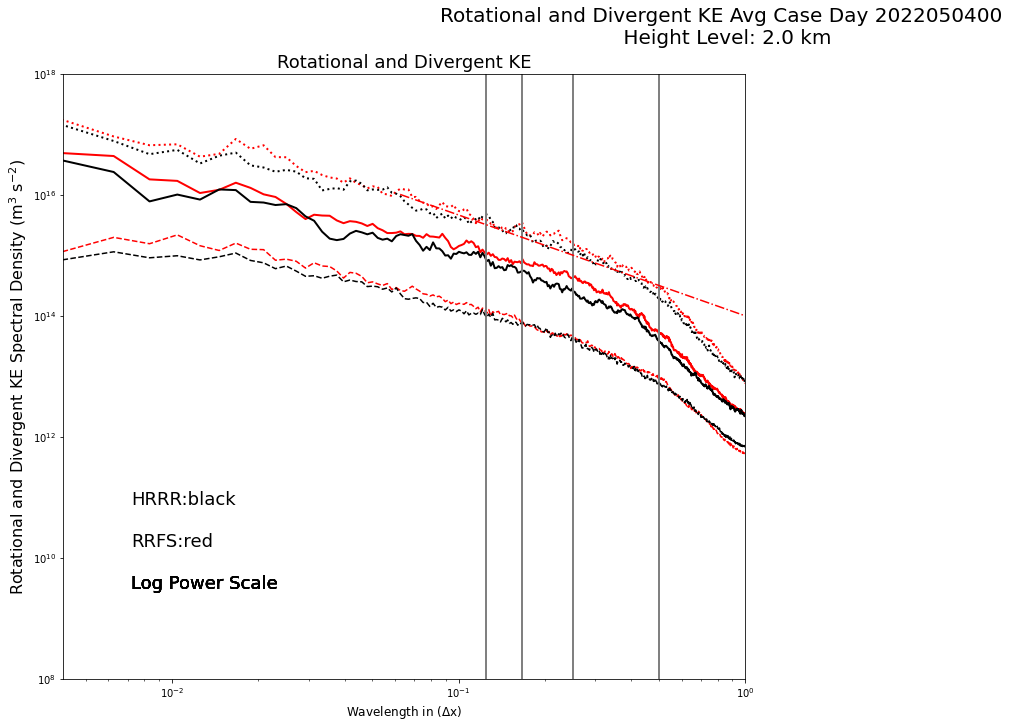

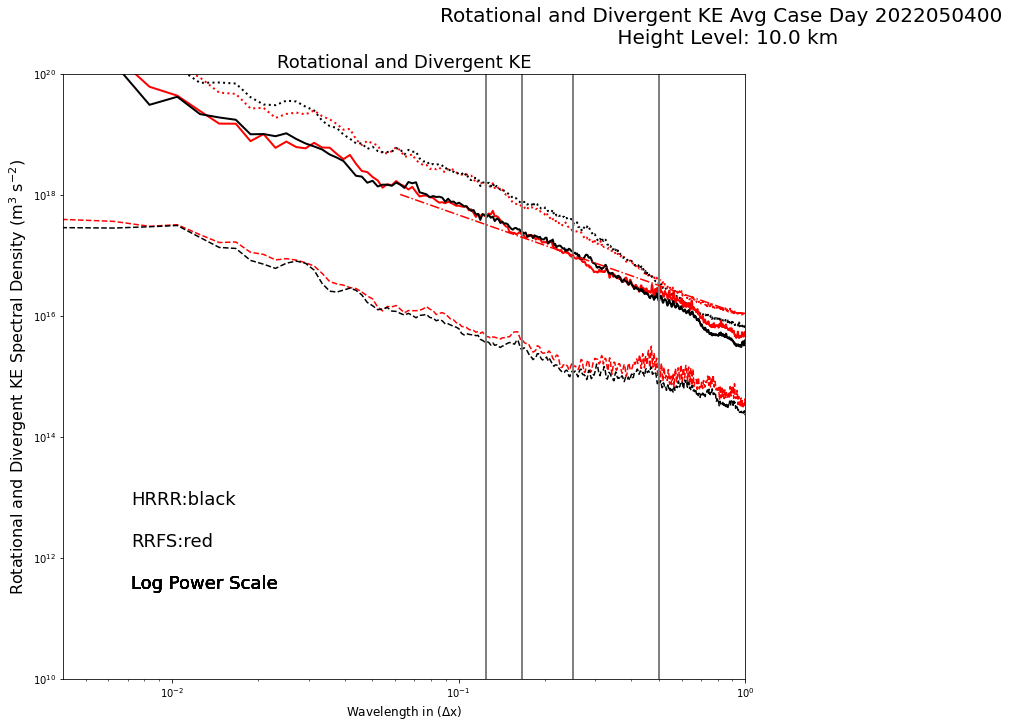

In [5]:
in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400"]

            # ["2022050400"]
            # # ,"2022051200",
            # # "2022051400",
            # # "2022051500",
            # # "2022051900",
            # # "2022052300",
            # # "2022052400",
            # # "2022052700",
            # # "2022053000",
            # # "2022060700"]

#case_days = ["2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d, analysis_levels = [4, 34])
    


====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS_nhhd2D.nc

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called



----> Processing run: RRFS for day:  2022050400 

          /work/wicker/ECONUS/2022050400_RRFS_ECONUS_nhhd2D.nc

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


                

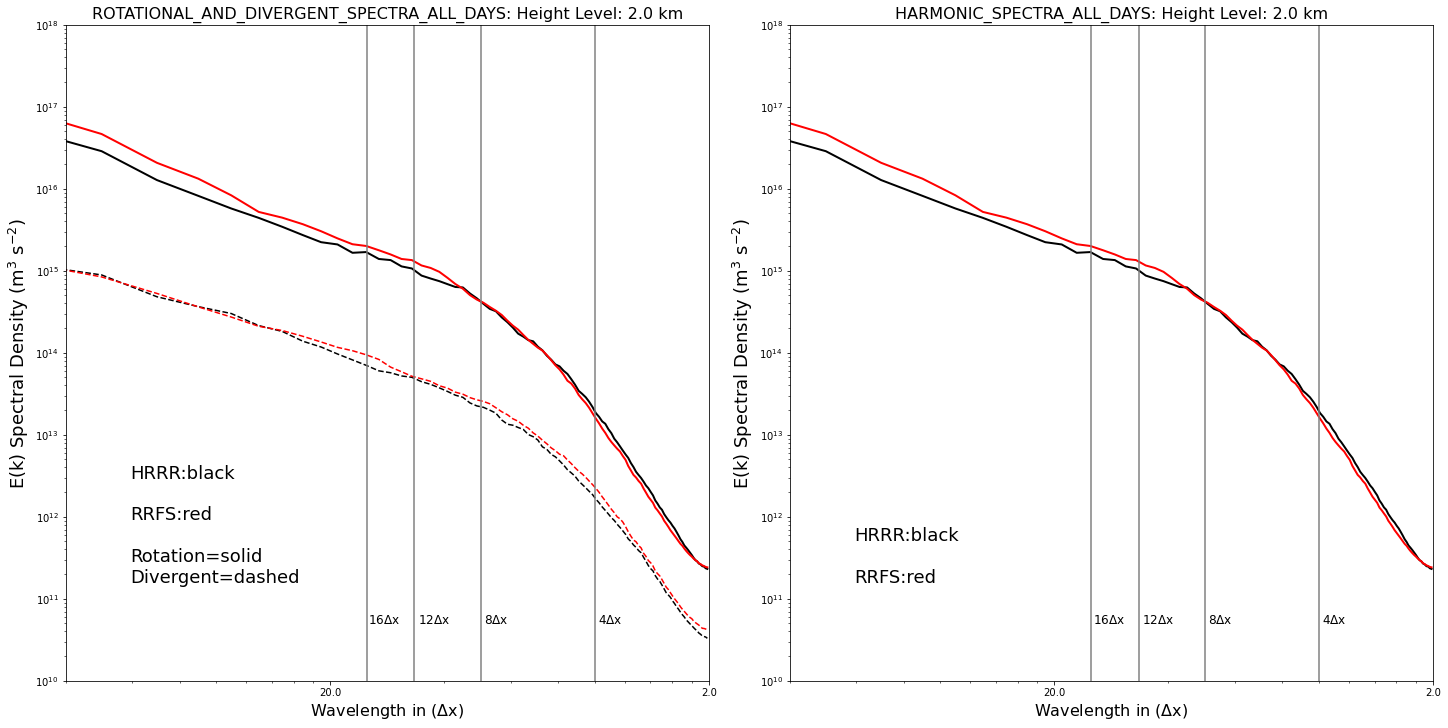

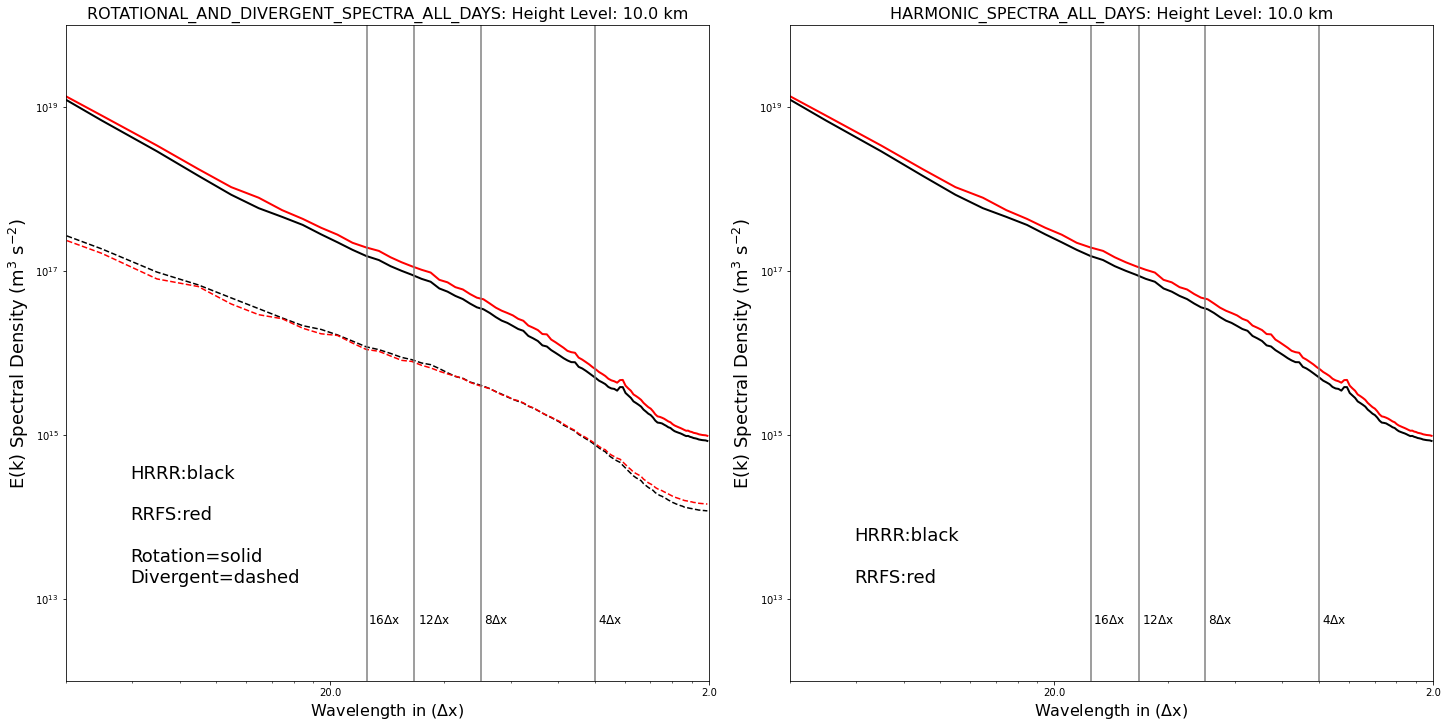

In [47]:
import matplotlib.ticker as mticker

analysis_levels  = [4, 34]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"

case_days = ["2022050400",
             "2022051200",
             "2022051400",
             "2022051500",
             "2022051900",
             "2022052300",
             "2022052400",
             "2022052700",
             "2022053000",
             "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_rke =  {"HRRR":[], 
            "RRFS":[]}

ret_dke =  {"HRRR":[], 
            "RRFS":[]}

ret_hke =  {"HRRR":[], 
            "RRFS":[]}

avg_rke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_dke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_hke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func   = get_spectra2D_RAD
dtrend = True
axis   = None

delta  = False

suffix_names = ["HRRR","RRFS"]
region       = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_%s_nhhd2D.nc" % (day, run, region)))
            print("          %s\n" % myfile)

            # Open data set

            ds = xr.open_dataset(myfile)
            
            zlevels = ds.z
            
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.
            
            ur = np.nan_to_num(ds.ur.isel(fhour=1,nz=klevels).values).astype('float64')
            vr = np.nan_to_num(ds.vr.isel(fhour=1,nz=klevels).values).astype('float64')
        
            ud = np.nan_to_num(ds.ud.isel(fhour=1,nz=klevels).values).astype('float64')
            vd = np.nan_to_num(ds.vd.isel(fhour=1,nz=klevels).values).astype('float64')

            uh = np.nan_to_num(ds.ud.isel(fhour=1,nz=klevels).values).astype('float64')
            vh = np.nan_to_num(ds.vd.isel(fhour=1,nz=klevels).values).astype('float64')

            rke = 0.5*(ur**2 + vr**2)
            dke = 0.5*(ud**2 + vd**2)
            hke = 0.5*(uh**2 + vh**2)

            # Compute rke spectra...

            ret = get_spectraND(rke, func = func, dtrend = dtrend)

            ret_rke[run].append(ret)

            avg_rke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            # Compute dke spectra...

            ret = get_spectraND(dke, func = func, dtrend = dtrend)

            ret_dke[run].append(ret)

            avg_dke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            # Compute hke spectra...

            ret = get_spectraND(hke, func = func, dtrend = dtrend)

            ret_hke[run].append(ret)

            avg_hke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            ds.close()

# Now plot the average spectra

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    gs = gridspec.GridSpec(1, 2, figure=fig)

    axes = fig.add_subplot(gs[0, 0])

    legend='HRRR:black\n\nRRFS:red\n\nRotation=solid\nDivergent=dashed'

    rke_hrrr = avg_rke['HRRR'].mean(axis=0)
    rke_rrfs = avg_rke['RRFS'].mean(axis=0)
    
    dke_hrrr = avg_dke['HRRR'].mean(axis=0)
    dke_rrfs = avg_dke['RRFS'].mean(axis=0)

    axes.loglog(avg_grid, rke_hrrr, color='black', linewidth=2.)
    axes.loglog(avg_grid, rke_rrfs, color='red',   linewidth=2.)
    
    axes.loglog(avg_grid, dke_hrrr, color='black', linestyle='--')
    axes.loglog(avg_grid, dke_rrfs, color='red',   linestyle='--')

    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.15), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    if k < 8:
            ylim = [1.0e10,1.0e18]
    else:
        ylim = [1.0e12,1.0e20]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)
    plt.title("ROTATIONAL_AND_DIVERGENT_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)
    
    # HKE spectra
    
    axes = fig.add_subplot(gs[0, 1])

    legend='HRRR:black\n\nRRFS:red'

    hke_hrrr = avg_rke['HRRR'].mean(axis=0)
    hke_rrfs = avg_rke['RRFS'].mean(axis=0)
    
    axes.loglog(avg_grid, hke_hrrr, color='black', linewidth=2.)
    axes.loglog(avg_grid, hke_rrfs, color='red',   linewidth=2.)
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.15), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    if k < 8:
        ylim = [1.0e10,1.0e18]
    else:
        ylim = [1.0e12,1.0e20]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.title("HARMONIC_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'W_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)



In [ ]:
import matplotlib.ticker as mticker

analysis_levels  = [4, 34]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_RAD
dtrend = False
axis = None

delta = False

suffix_names = ["HRRR","RRFS"]
region = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            
            zlevels = data.z
            
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_u = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            data_v = np.nan_to_num(data.v_interp.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = get_spectraND(data_u, varray=data_v, func = func, detrend=dtrend)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()

# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [1.0e1,1.0e6]

    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.0075, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)
        
    xpt = [2.0/16.,2.0/2.0]
    dlnx = np.log(xpt[1]) - np.log(xpt[0])
    y1   = ylim[1]/(100.)
    y0   = np.exp(np.log(y1) + 5./3. * dlnx)
    ypt  = [y0,y1]
    axes.loglog(xpt, ypt, color='red',linestyle='-.',label='k$^{-5/3}$')

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"KE Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.suptitle("KE_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'KE_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)
    
    